In [1]:
import os, cv2, numpy as np, scipy.io, tensorflow as tf, pathlib

IMG_SIZE = 256
BATCH_SIZE = 4

IMG_ROOT = "data/images"
MAT_ROOT = "data/groundTruth"

def load_pair(img_path_b, split_b):
    """py_function body: img_path_b and split_b arrive as EagerTensors."""
    img_path = img_path_b.numpy().decode()          # bytes → str
    split    = split_b.numpy().decode()             # e.g. "train"

    # ---------- derive matching .mat ----------
    basename = os.path.splitext(os.path.basename(img_path))[0]
MAT_ROOT = "data/groundTruth"

    # ---------- read RGB ----------
    rgb = cv2.imread(img_path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    # ---------- edge from .mat ----------
    mat = scipy.io.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    edge = np.zeros(mat["groundTruth"][0].Boundaries.shape, dtype=np.float32)
    for ann in np.atleast_1d(mat["groundTruth"]):
        edge = np.maximum(edge, ann.Boundaries)
    edge = cv2.resize(edge, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    edge = (edge > 0.1).astype(np.uint8) * 255
    edge = cv2.dilate(edge, None, iterations=1)
    edge = edge[..., None]

    # ---------- scale to [-1,1] ----------
    rgb  = (rgb.astype(np.float32) / 127.5) - 1.0
    edge = (edge.astype(np.float32) / 127.5) - 1.0
    return edge, rgb

def _set_shapes(edge, rgb):
    edge.set_shape([IMG_SIZE, IMG_SIZE, 1])   # (H,W,1)
    rgb.set_shape ([IMG_SIZE, IMG_SIZE, 3])   # (H,W,3)
    return edge, rgb

def make_bsds_dataset(split: str, *, batch: bool = True) -> tf.data.Dataset:
    """
    Returns a tf.data.Dataset yielding (edge, photo).
       split : 'train' | 'val' | 'test'
       batch : if True, batches inside the function; if False, leaves unbatched
    """
    files = tf.data.Dataset.list_files(
IMG_ROOT = "data/images"

    ds = files.map(
        lambda p: tf.py_function(load_pair,
                                 inp=[p, tf.constant(split.encode())],
                                 Tout=(tf.float32, tf.float32)),
        num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.map(_set_shapes, num_parallel_calls=tf.data.AUTOTUNE)

    if batch:                               # ← new optional behaviour
        ds = ds.batch(BATCH_SIZE)

    return ds.prefetch(tf.data.AUTOTUNE)
    
train_ds = make_bsds_dataset("train")
val_ds   = make_bsds_dataset("val")


2025-06-11 01:14:55.651117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
edge_b, rgb_b = next(iter(train_ds))
print(edge_b.shape, rgb_b.shape)   # (B,256,256,1)  (B,256,256,3)


(4, 256, 256, 1) (4, 256, 256, 3)


In [2]:
edge_b, rgb_b = next(iter(make_bsds_dataset("train", batch=False)))
print(edge_b.shape, rgb_b.shape)   # (B,256,256,1)  (B,256,256,3)

(256, 256, 1) (256, 256, 3)


In [3]:
train_ds = make_bsds_dataset("train")   # 200 training images
val_ds   = make_bsds_dataset("val")     # 100 validation images


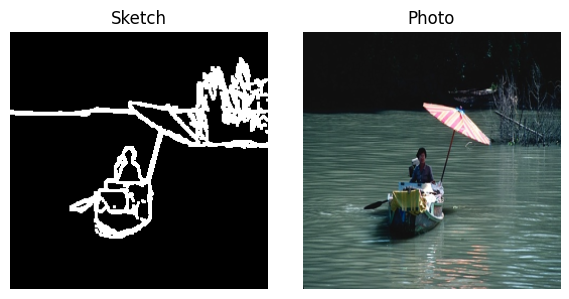

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

edge_batch, rgb_batch = next(iter(train_ds))

edge = edge_batch[0].numpy()
rgb  = rgb_batch[0].numpy()

edge_display = (edge + 1) / 2.0
rgb_display  = (rgb  + 1) / 2.0

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1); plt.title("Sketch");  plt.imshow(edge_display.squeeze(), cmap="gray"); plt.axis("off")
plt.subplot(1, 2, 2); plt.title("Photo");   plt.imshow(rgb_display);             plt.axis("off")
plt.tight_layout(); plt.show()


In [5]:
# The facade training set consist of 400 images
BUFFER_SIZE = 200
# The batch size setting
BATCH_SIZE = 4
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
# ------------------------------------------------------------
# constants
IMG_HEIGHT = 256
IMG_WIDTH  = 256
JIT_SIZE   = 286
# ------------------------------------------------------------

def resize(edge, photo, h, w):
    """Resize sketch with NN, photo with bilinear."""
    edge  = tf.image.resize(edge,  [h, w], method="nearest")   # keeps hard lines
    photo = tf.image.resize(photo, [h, w], method="bilinear")  # smoother
    return edge, photo


def random_crop(edge, photo):
    """
    Concatenate along channels → random crop → split back.
    edge  : (H,W,1)   photo : (H,W,3)
    out   : (256,256,1) , (256,256,3)
    """
    # concat => (H,W,4)
    combined = tf.concat([edge, photo], axis=-1)
    combined = tf.image.random_crop(combined,
                                    size=[IMG_HEIGHT, IMG_WIDTH, 4])
    edge_cropped  = combined[..., :1]    # first channel
    photo_cropped = combined[..., 1:]    # remaining 3
    return edge_cropped, photo_cropped


def normalize(edge, photo):
    """
    Loader already scales to [-1,1]; keep for API completeness.
    If you use other datasets, ensure their loader outputs raw 0-255 and
    call this function afterwards.
    """
    return edge, photo


@tf.function
def random_jitter(edge, photo):
    edge, photo = resize(edge, photo, JIT_SIZE, JIT_SIZE)
    edge, photo = random_crop(edge, photo)

    if tf.random.uniform(()) > 0.5:
        edge  = tf.image.flip_left_right(edge)
        photo = tf.image.flip_left_right(photo)

    return edge, photo


In [7]:
train_ds = (make_bsds_dataset("train", batch=False)
            .map(random_jitter, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))


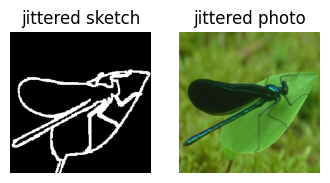

In [8]:
edge_b, photo_b = next(iter(train_ds))
plt.figure(figsize=(4,2))
plt.subplot(1,2,1); plt.imshow((edge_b[0]+1)/2, cmap='gray'); plt.axis('off'); plt.title('jittered sketch')
plt.subplot(1,2,2); plt.imshow((photo_b[0]+1)/2); plt.axis('off'); plt.title('jittered photo')
plt.show()


In [9]:
OUTPUT_CHANNELS = 3

In [10]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [12]:
edge_b, rgb_b = next(iter(train_ds))
print(edge_b.shape, rgb_b.shape)   # (BATCH_SIZE, 256, 256, 1)  (BATCH_SIZE, 256, 256, 3)


(4, 256, 256, 1) (4, 256, 256, 3)


In [13]:
# 1️⃣ grab one (sketch, photo) pair from the dataset  –– NO batching
edge_sample, _ = next(iter(make_bsds_dataset("train", batch=False)))

# edge_sample has shape (256,256,1) in [-1,1].
# If your downsample() is channel-agnostic (Conv2D filters=3), that's fine.
# If it anticipates 3-channel input, replicate the single channel:
inp = tf.tile(edge_sample, [1, 1, 3])   # (256,256,3)

# 2️⃣ run the downsample sanity-check
down_model   = downsample(3, 4)          # tiny test block
down_result  = down_model(tf.expand_dims(inp, 0))  # add batch dim
print(down_result.shape)                 # e.g. (1, 128, 128, 3)

(1, 128, 128, 3)


In [14]:
def res_block(filters, kernel_size=3):
    """
    Residual block:
        Conv → BN → ReLU → Conv → BN → add shortcut
    Spatial size is preserved (padding='same').
    """
    init = tf.random_normal_initializer(0., 0.02)
    seq  = tf.keras.Sequential()

    # first conv
    seq.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=1,
                                   padding='same',
                                   kernel_initializer=init, use_bias=False))
    seq.add(tf.keras.layers.BatchNormalization())
    seq.add(tf.keras.layers.ReLU())

    # second conv
    seq.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=1,
                                   padding='same',
                                   kernel_initializer=init, use_bias=False))
    seq.add(tf.keras.layers.BatchNormalization())

    # The Sequential block will output F(x).  We wrap it with Lambda
    # so we can add the shortcut x + F(x).
    return tf.keras.layers.Lambda(lambda x: x + seq(x))


In [15]:
res_model=res_block(3)
res_result=res_model(tf.expand_dims(inp, 0))
print(res_result.shape)

(1, 256, 256, 3)


In [16]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  #result.add(
  #  tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
  #                                 padding='same',
  #                                  kernel_initializer=initializer,
  #                                  use_bias=False))
  result.add(tf.keras.layers.UpSampling2D(size=2, interpolation="bilinear"))
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [17]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [57]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]


  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 3),  # (batch_size, 16, 16, 1024)
    upsample(256, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
    upsample(32, 3)  # (batch_size, 256, 256, 3)
    
  ]


  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 7,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)


 # skips = reversed(skips[:-1])
  # Bottleneck residual capacity
  for _ in range(6):
    x = res_block(512)(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = up_stack[-1](x)  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [58]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [59]:
# one (edge, rgb) pair from the unbatched dataset
edge, rgb = next(iter(make_bsds_dataset("train", batch=False)))

print(edge.shape)   # (256, 256, 1)  ← one channel


(256, 256, 1)


In [60]:
gen_output = generator(edge[tf.newaxis, ...], training=False)   # shape (1,256,256,3)


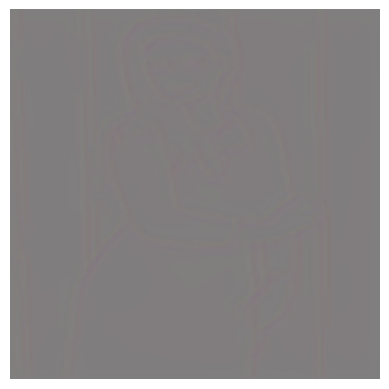

In [61]:
import matplotlib.pyplot as plt

# rescale from [-1,1] → [0,1] for display
plt.imshow((gen_output[0] + 1) / 2)
plt.axis("off"); plt.show()


In [29]:
#gen_output = generator(inp[tf.newaxis], training=False)
#gen_output = generator(inp[tf.newaxis, ...], training=False)
#plt.imshow(gen_output[0, ...])

In [62]:
LAMBDA = 100

In [63]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [65]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [66]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='sketch')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='photo')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [67]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [69]:
edge_sample, _ = next(iter(make_bsds_dataset("train", batch=False)))
edge_batched   = edge_sample[tf.newaxis, ...]          # shape (1,256,256,1)

gen_output = generator(edge_batched, training=False)   # shape (1,256,256,3)
disc_out   = discriminator([edge_batched, gen_output], training=False)


In [72]:
print(edge_batched.shape)   # (1, 256, 256, 1)
print(gen_output.shape)     # (1, 256, 256, 3)

disc_out = discriminator([edge_batched, gen_output], training=False)
print(disc_out.shape)       # (1, 30, 30, 1)  ← PatchGAN logits


(1, 256, 256, 1)
(1, 256, 256, 3)
(1, 30, 30, 1)


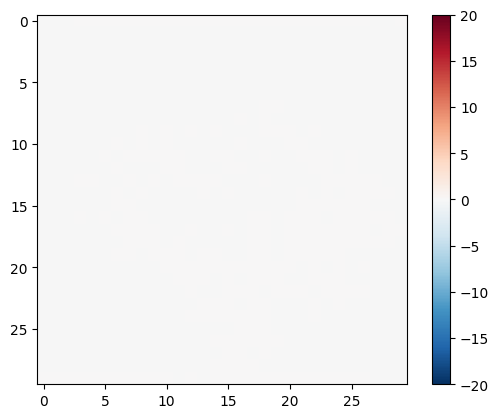

In [74]:
disc_out = discriminator([edge_batched, gen_output], training=False)
plt.imshow(disc_out[0, ..., 0], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


In [73]:
disc_out = discriminator([edge_batched[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

ValueError: Input 0 of layer "functional_108" is incompatible with the layer: expected shape=(None, 256, 256, 1), found shape=(1, 1, 256, 256)

In [75]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [76]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [77]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [78]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

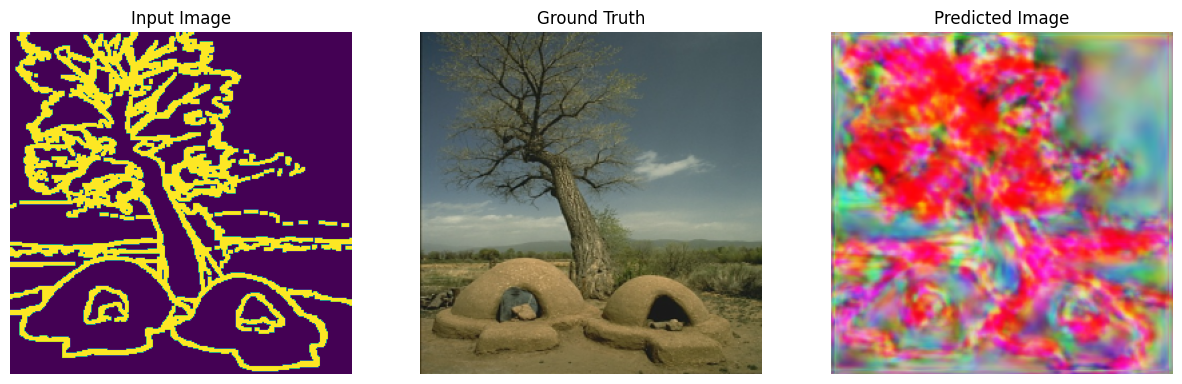

2025-06-11 01:29:43.611942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [81]:
for example_input, example_target in val_ds.take(1):
  generate_images(generator, example_input, example_target)

In [82]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [93]:
import time
import datetime
import os
from IPython import display

def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 33.26 sec



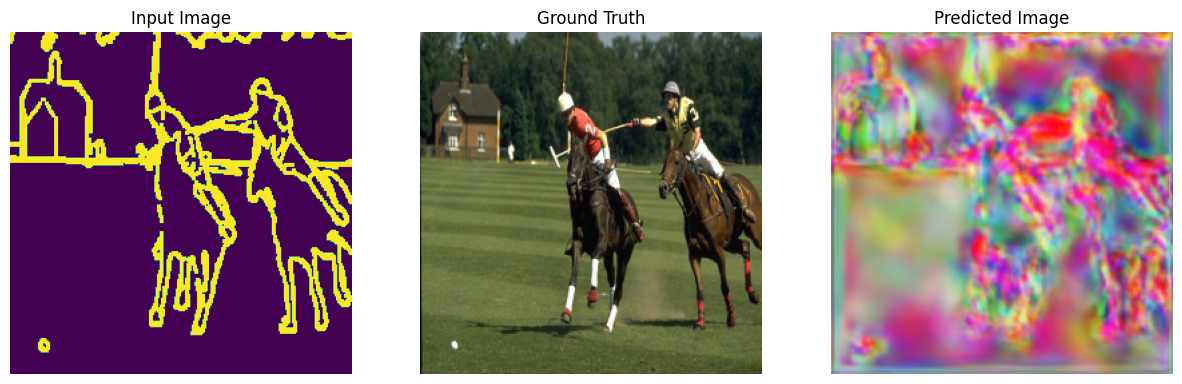

Step: 39k
....................................................................................................

2025-06-11 01:58:32.081562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [96]:
fit(train_ds, val_ds, steps=40000)

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)